# Teseract Text Recognition
1. PSM Explained : https://pyimagesearch.com/2021/11/15/tesseract-page-segmentation-modes-psms-explained-how-to-improve-your-ocr-accuracy/

In [120]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np  
import datetime
from pytesseract import Output
import pandas as pd
pytesseract.pytesseract.tesseract_cmd = 'S:\\Tesseract-OCR\\tesseract.exe'


In [102]:
# Menampilkan gambar
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

# Cropping gambar
def manualCrop(img, y0, yt, x0, xt):
    return img[y0:yt, x0:xt]

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def invert(img):
    return cv2.bitwise_not(img)
    
def grayscale_img(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def threshold(image, x0, xt):
    thresh, img_thr = cv2.threshold(image, x0, xt, cv2.THRESH_BINARY)
    return img_thr

def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

def noise_remove(img):
    return cv2.fastNlMeansDenoising(img, None, 20, 7, 21) 

def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)
  
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return (image)

def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("research/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage
    
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

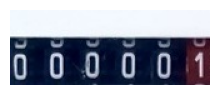

In [105]:
img_ori = cv2.imread('G:/Program/Python/OCR_Detection/research/itron_meteran.jpg')
cropped = manualCrop(img_ori, 160, 220,  210, 370)
rotated = rotateImage(cropped, -1.15)
cv2.imwrite('G:/Program/Python/OCR_Detection/research/rotated.jpg', rotated)
display('G:/Program/Python/OCR_Detection/research/rotated.jpg')

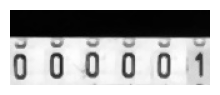

0.1

In [141]:
inverted = invert(rotated)
grayscaleImg = grayscale_img(inverted)
noiseRemove = noise_removal(grayscaleImg)
cv2.imwrite('G:/Program/Python/OCR_Detection/research/noiseRemove.jpg', noiseRemove)
display('G:/Program/Python/OCR_Detection/research/noiseRemove.jpg')
nilai = pytesseract.image_to_string(noiseRemove, config = r'--oem 3 --psm 10 digits')
nilai_kwh = float(nilai[0])*10.0**4 + float(nilai[1])*10**3 + float(nilai[2])*10**2 + float(nilai[3])*10**1 + float(nilai[4])*10**0 + float(nilai[5])*10**-1

In [147]:
text = pytesseract.image_to_data(noiseRemove, config = r'--oem 3 --psm 10 ', output_type=pytesseract.Output.DICT)
print(text['text'][4])
conf = []
for i in text['conf']:
    if i != -1:
        conf.append(float(float(i)/100.0))
if len(conf) != 0:
    score = (sum(conf)/len(conf))*100.0

print(score)

000001
93.0


In [130]:
def timeStamp():
    dateTimeObj = datetime.datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y %H:%M:%S")
    return  timestampStr

timeStamp()

'02-Sep-2022 14:23:47'